# Problem statement
There is some service where users can interact with each other and as well purchase some items. There was conducted event on that service from 1st of May until 2nd of May to promote items with hope that it will increase number purchases. That event was available to everyone who visited platform during those two days and it is necessary to understand if that event indeed helped changed user behaviour.

Available data is: <br>
- users service login data from 1st of April thru 30th of April <br>
- users purchase log from 1st of May thru 13th of May <br>
- list of users who participated in the event <br>

### Approach
In order to measure impact from event we need somehow to divide users into those who participated in the event and those who didn't and then measure difference between those two groups in the period during and after event. Moreover, we need to make sure that users in test and control groups are similar to each other (there is no selection bias) and the only difference between them is the fact that users from test group participated in event and users from control didn't. 
In some settings it is possible to achieve that by creating randomized test and control groups before event, however, in this case since event was available to everyone that approach won't work. Instead, we would need to create artificial test and control group post event and make sure there is no selection bias. There are several ways for that, i.e propensity score matching or stratification, which we are going to try below.

Given available data, we only can judge whether or not users are similar to each other before event based on login data, e.g. frequency of service login in April. 

So let's load data and proceed with proposed approach.


### Loading and inspecting data


In [53]:
library(dplyr)
library(ggplot2)
library(tidyverse)
library(MatchIt)

# loading login data and converting timestamp from factor to time
login = read.csv("user_login.csv")
login$timestamp = as.POSIXct(strptime(login$timestamp, format = "%Y-%m-%d %H:%M:%S"))
# checking the range for login data
range(login$timestamp)

[1] "2016-04-01 00:01:03 JST" "2016-04-30 23:59:52 JST"

In [54]:
# loading purchases data and converting timestamp from factor to time
purchases = read.csv("item_purchase_log.csv")
purchases$timestamp = as.POSIXct(strptime(purchases$timestamp, format = "%Y-%m-%d %H:%M:%S"))
# checking the range for purchase data
range(purchases$timestamp)

[1] "2016-05-01 00:20:48 JST" "2016-05-13 21:44:36 JST"

In [55]:
# loading event participant data and converting timestamp from factor to time
participants = read.csv("event_entry_users.csv")
participants$timestamp = as.POSIXct(strptime(participants$timestamp, format = "%Y-%m-%d %H:%M:%S"))
# checking the range for event participants 
range(participants$timestamp)

[1] "2016-05-01 00:03:11 JST" "2016-05-02 23:59:51 JST"

let's aggregate and merge data in one dataframe

In [68]:
# counts how many times each user accessed service in April and as well
# vist counts at the beginning, middle and end of April
login_summary = login %>% 
                  group_by(user_id) %>% 
                    summarize(visits = n(),
                                visits_10 = sum(timestamp < "2016-04-11"),
                                visits_20 = sum(timestamp < "2016-04-21" & timestamp >= "2016-04-11") ,
                                visits_30 = sum(timestamp <= "2016-05-01" & timestamp >= "2016-04-21")) %>%
                      as.data.frame()

# dividing purchase events into two periods: within event (from 1st to 2nd of may) and outside of the event 
# after 2nd of May
purchases_summary = purchases %>%
                      group_by(user_id) %>% 
                        summarize(purchased_within_campaign = sum(timestamp < "2016-05-03"),
                                  purcahsed_outside_campaign = sum(timestamp >= "2016-05-03"), 
                                  purchased_total = purchased_within_campaign + purcahsed_outside_campaign) %>% 
                            as.data.frame()

# participants data frame has list of users who participated in the event, one user can participate in the event
# several times, so we are creating data frame that has unique list users who participated in the event
participants_summary = data.frame(user_id = unique(participants$user_id), is_participated = 1)

# merging aggregated data frames together and filling NA
total = merge(login_summary, participants_summary, all = T)
total = merge(total, purchases_summary, all = T)

# filling NAs
# all users who are not in the participants summary data frame didn't participate in the event
total$is_participated = as.character(total$is_participated)
total[is.na(total$is_participated),]$is_participated = 0
total[is.na(total$purchased_within_campaign),]$purchased_within_campaign = 0
total[is.na(total$purcahsed_outside_campaign),]$purcahsed_outside_campaign = 0
total[is.na(total$purchased_total),]$purchased_total = 0

head(total)

user_id,visits,visits_10,visits_20,visits_30,is_participated,purchased_within_campaign,purcahsed_outside_campaign,purchased_total
u00000001,36,13,11,12,1,0,0,0
u00000002,30,11,8,11,1,0,0,0
u00000003,10,2,4,4,0,0,0,0
u00000004,16,6,6,4,1,0,0,0
u00000005,4,3,1,0,0,0,0,0
u00000006,29,10,9,10,0,0,0,0


As it was mentioned before, we need to make sure test and control groups are similar to each other in terms of visits frequency in April as it is only avaiable data before campaign. So let's see how similiar to each other event participants and not participants.

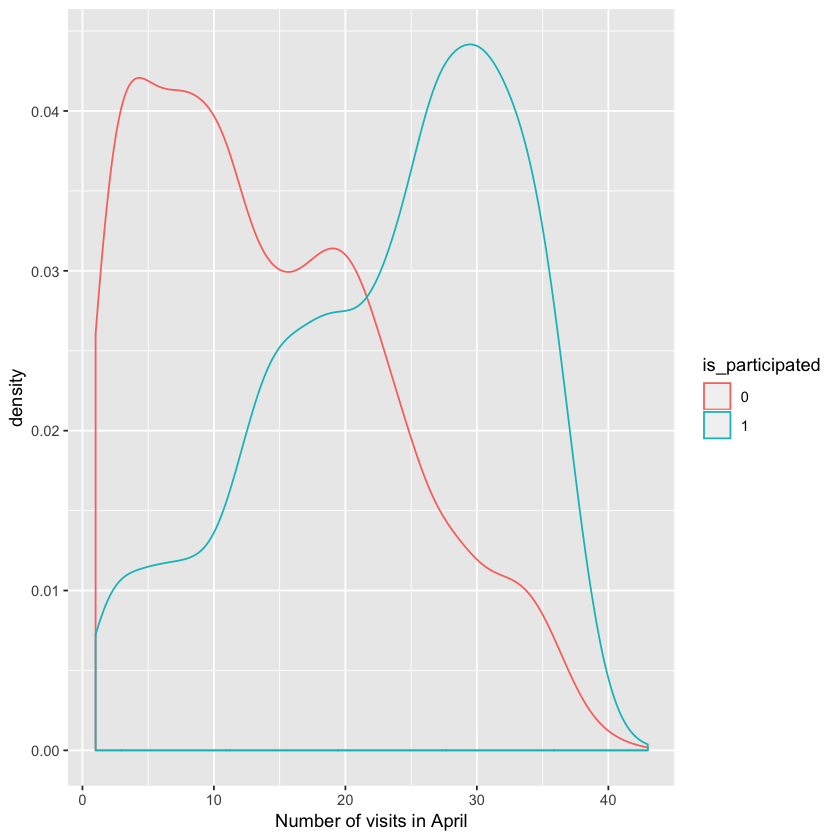

In [58]:
ggplot(total, aes(x = visits, color = is_participated)) + geom_density() + xlab("Number of visits in April")

As we can see  users who participated in event and users who didn't have very different behaviour before event - event participants are more frequent visitors before the event. This makes sense: there is higher chance for high frequency members to participate in the event, because they had higher chance to visit service during 2 event days. Because behaviour is so different we can't compare directly event participants with not event participants during and after event. We need to pick users from not event participants who are more similiar to the test group. There are various methods for that, i.e. propensity score matching, stratification etc. Let's try both approaches below.

### Creating test and control groups: stratification approach

There are following steps in case of stratification approach: <br>
- check visits frequency distribution in April for both users who joined and didn't join the event
- align distributions by sampling randomly appropriate number of users for each strata (frequency bin), so the share of every strata becomes identical 


In [60]:
# checks user count in each frequency bin for both test and control users and calculates size that 
# would be pulled randomly from each group (0.8*min(test_size, control_size)) 

frequency_tbl = 
total %>% 
    group_by(is_participated, visits) %>% 
        summarise(frequency = n()) %>% 
            spread( is_participated, frequency, fill = 0)  
frequency_tbl$sample_size = round(0.8*apply(frequency_tbl[!names(frequency_tbl) %in% 'visits'], 1, FUN=min))
head(frequency_tbl)

visits,0,1,sample_size
1,172,39,31
2,172,57,46
3,199,33,26
4,180,41,33
5,185,49,39
6,157,41,33


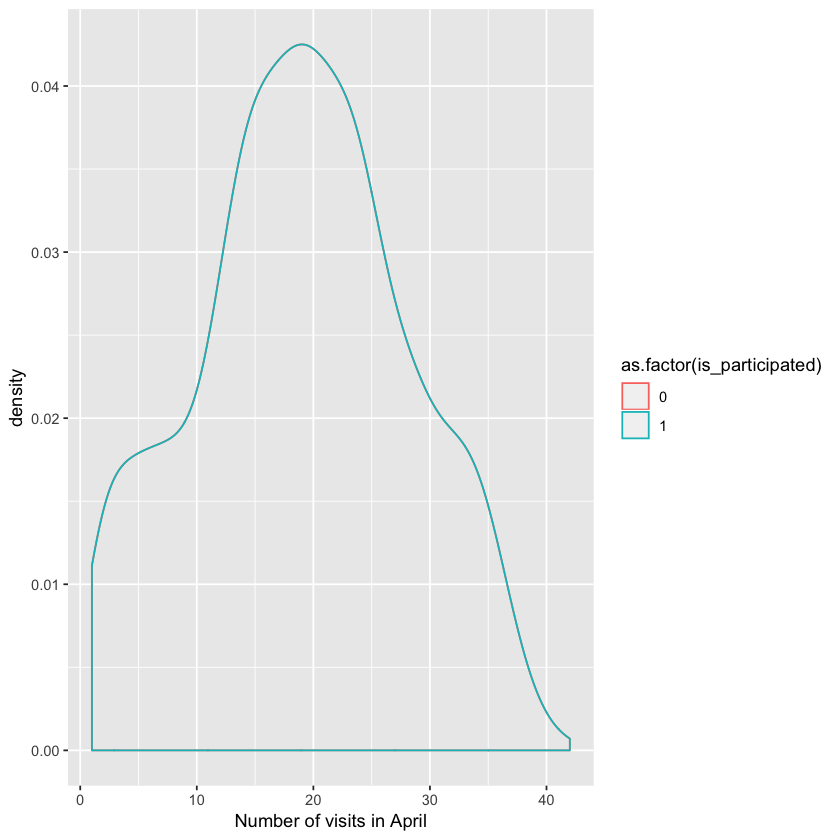

In [62]:
# applying sampling and building new test and control groups:
control = data.frame()
test = data.frame()
for (freq in  frequency_tbl$visits) {
    size = frequency_tbl[frequency_tbl$visits == freq,]$sample_size
    control_pool = total[total$visits == freq & total$is_participated == 0,]
    test_pool = total[total$visits == freq & total$is_participated == 1,]
    control = rbind(control, control_pool[control_pool$user_id %in% sample(control_pool$user_id,size), ])
    test = rbind(test, test_pool[test_pool$user_id %in% sample(test_pool$user_id,size), ])
}
control$is_participated = 0
test$is_participated = 1
groups_strata = rbind(test, control)
ggplot(groups_strata, aes(x = visits, color = as.factor(is_participated))) + geom_density() + xlab("Number of visits in April")

As we can see now distributions are very much aligned and there is no difference between test and control groups in terms of frequency visitation in April

### Creating test and control groups: propensity score matching

Let's try to make sure that users in test in control group are not only aligned on number of visits but also on distribution of those visits in April, e.g. some user might have more visits in the beginning of April and no visits at the end and that can impact his event attendence. To take that into account, let's use propensity score matching approach: <br>
- propensity score is calculated for each user from the set of covariates (which we would like to align on), i.e. visits_10, visits_20 and visits_30 using for example logistic regression. We don't need to add visits variable as well as visits = visits_10 + visits_20 + visits_30 (linear dependency)
- Then users with similar propensity score from test and control pools are matched to each other 



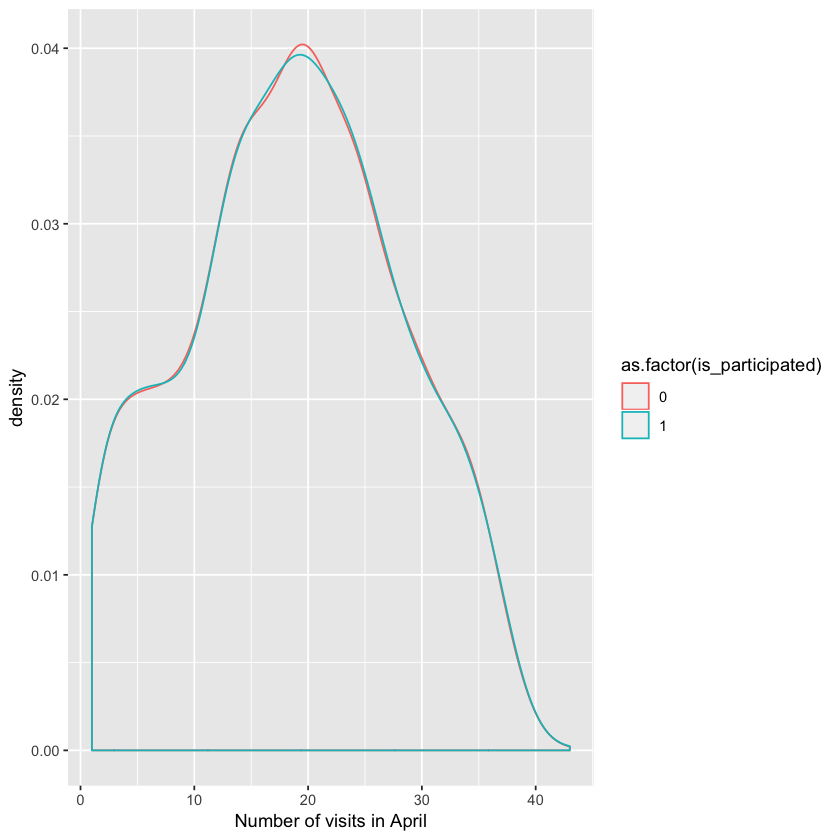

In [67]:
matching = matchit(is_participated ~ visits_10  + visits_20 + visits_30, data = total, method = "cem", k2k = TRUE)
groups_propensity = match.data(matching)
ggplot(groups_propensity, aes(x = visits, color = as.factor(is_participated))) + geom_density() + xlab("Number of visits in April")

As we can see, visits distributions in April became more aligned also not as aligned as in case of stratification method (which makes sense as we used several covariates to align on). We can check how groups are aligned in terms of other variables as well.

In [69]:
groups_propensity %>% group_by(is_participated) %>% summarize(
    visits = mean(visits),
    visits_10 = mean(visits_10),
    visits_20 = mean(visits_20),
    visits_30 = mean(visits_30)
)

is_participated,visits,visits_10,visits_20,visits_30
0,18.77973,6.263559,6.297812,6.218363
1,18.78735,6.262607,6.301142,6.223597


And we can compare it with strata approach:

In [70]:
groups_strata %>% group_by(is_participated) %>% summarize(
    visits = mean(visits),
    visits_10 = mean(visits_10),
    visits_20 = mean(visits_20),
    visits_30 = mean(visits_30)
)

is_participated,visits,visits_10,visits_20,visits_30
0,19.08097,6.398143,6.345023,6.337803
1,19.08097,6.355338,6.412584,6.313048


### Measuring impact

As we have matched groups now, we can check if there is any difference between test and control groups during and after event

In [76]:
summary = groups_strata %>% 
    group_by(is_participated) %>% 
    summarize(members = n(), 
              visits = round(mean(visits),1),
              buyers_total = sum(purchased_total > 0), 
              conversion_total = round(buyers_total/members,2),
              items_total = sum(purchased_total),
              items_per_buyer_total = round(items_total/buyers_total,2)
              ) %>%
  as.data.frame()
summary

is_participated,members,visits,buyers_total,conversion_total,items_total,items_per_buyer_total
0,1939,19.1,240,0.12,240,1.00
1,1939,19.1,229,0.12,246,1.07


In [73]:
groups_propensity %>% 
    group_by(is_participated) %>% 
    summarize(members = n(), 
              visits = round(mean(visits),1),
              buyers_total = sum(purchased_total > 0), 
              conversion_total = round(buyers_total/members,2),
              items_total = sum(purchased_total),
              items_per_buyer_total = round(items_total/buyers_total,2)
              ) %>%
  as.data.frame()

is_participated,members,visits,buyers_total,conversion_total,items_total,items_per_buyer_total
0,2102,18.8,262,0.12,262,1.00
1,2102,18.8,252,0.12,273,1.08


Regadless of matched groups, we got comparable results:<br>
- control group has slightly higher number of buyers
- buyers in test group purchased more items and total number of purchased items is higher in test group

Now we can run statistical test for any of matched groups and see if there is significant difference in number of buyers or number of purchased items between test and control groups 


In [83]:
# total conversion, one tailed test since we assume that event has positive effect on conversion 
pvalue_total = prop.test(matrix(c(summary$buyers_total[2], 
                              summary$members[2] - summary$buyers_total[2],
                              summary$buyers_total[1],
                              summary$members[1] -   summary$buyers_total[1]),
                            ncol = 2), alternative = "greater")$p.value


# test for items per buyer
#total purchases
chisq_total = chisq.test(table(groups_strata$purchased_total, groups_strata$is_participated))$p.value
print(c(pvalue_total, chisq_total))
# None of event not participants have purchased twice in the observation period, therefore items per buyer in control group is 1. Among event participants noone purchased twice during event, therefore items per buyer within event is 1 for test group and thus it doesn't make sence to calculate chisq test for period within event.

[1] 0.68881613560 0.00008397396


Difference in number of buyers is not significant and there is significant difference in number of purchase

In [85]:
table(groups_strata$purchased_total, groups_strata$is_participated)

   
       0    1
  0 1699 1710
  1  240  212
  2    0   17